In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pyprogressivex
from time import time

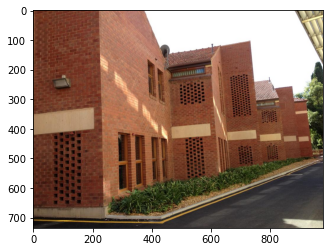

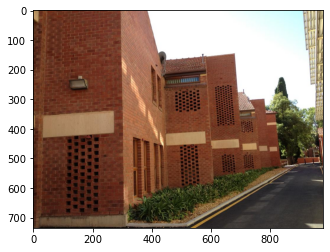

In [2]:
# Load the images
img1 = cv2.cvtColor(cv2.imread('img/unihouse1.png'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('img/unihouse2.png'), cv2.COLOR_BGR2RGB)
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [3]:
# Load the correspondences from file
correspondences = np.loadtxt('img/unihouse.txt')
n = len(correspondences)
kps1 = np.float32([correspondences[i][0:2] for i in np.arange(n)]).reshape(-1,2)
kps2 = np.float32([correspondences[i][3:5] for i in np.arange(n)]).reshape(-1,2)

print("Number of correspondences loaded = ", str(len(correspondences)))

Number of correspondences loaded =  2084


In [4]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)

def draw_matches(kps1, kps2, tentatives, img1, img2, mask):    
    matchesMask = mask.ravel().tolist()
    
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),kps1,decolorize(img2),kps2,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.show() 
    return

In [26]:
def verify_pyprogressivex(corrs):    
    n = len(corrs)
    sourcePoints = np.float32([corrs[i][0:2] for i in np.arange(n)]).reshape(-1,2)
    destinationPoints = np.float32([corrs[i][2:4] for i in np.arange(n)]).reshape(-1,2)
    
    threshold = 3.0
    
    homographies, labeling = pyprogressivex.findHomographies(sourcePoints, destinationPoints, threshold)    
    return homographies, labeling

In [27]:
t = time()

homographies, labeling = verify_pyprogressivex(correspondences)
model_number = homographies.size / 9

print ('Time = ', time()-t, ' sec')
print ('Models found = {}'.format(model_number))

Time =  1.0451805591583252  sec
Models found = 7.0


Drawing the points of the 1-th homography.


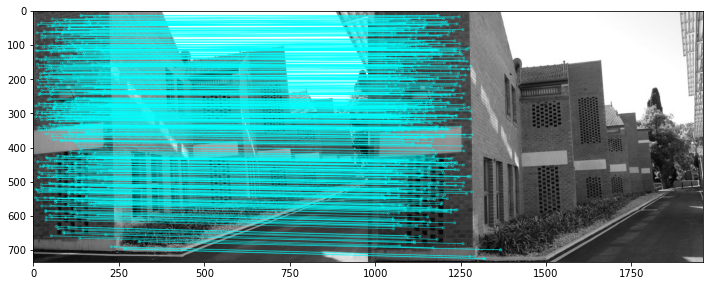

Drawing the points of the 2-th homography.


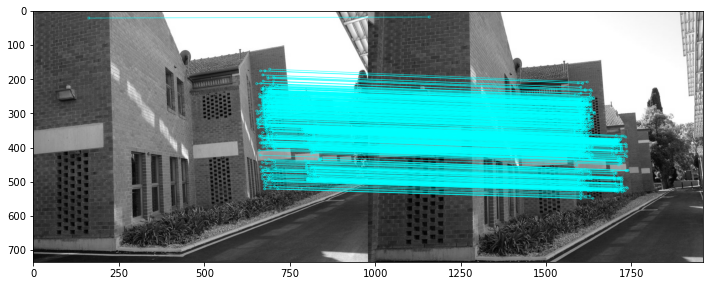

Drawing the points of the 3-th homography.


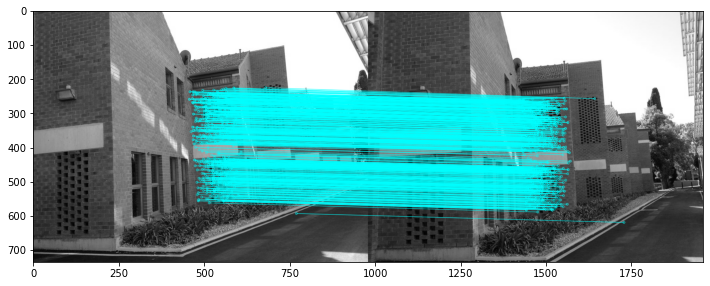

Drawing the points of the 4-th homography.


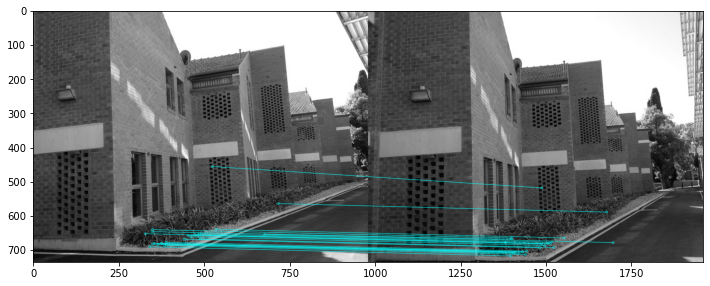

Drawing the points of the 5-th homography.


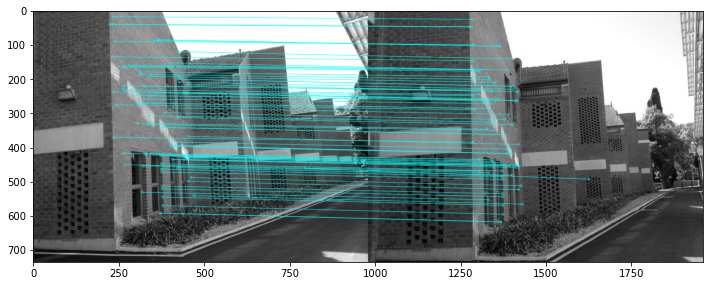

Drawing the points of the 6-th homography.


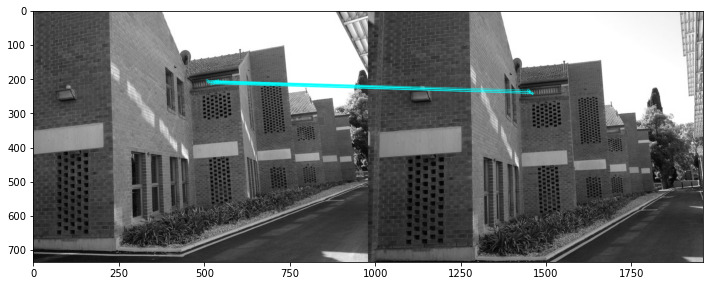

Drawing the points of the 7-th homography.


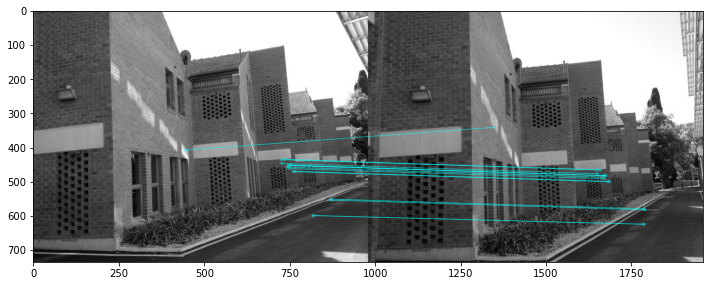

In [28]:
for hidx in np.arange(model_number):
    print("Drawing the points of the {}-th homography.".format(int(hidx + 1)))
    
    # Converting to OpenCV format 
    h,w,ch = img1.shape
    sourceKeypoints = [cv2.KeyPoint(correspondences[i][0], correspondences[i][1], 0) for i in np.arange(n)]
    destinationKeypoints = [cv2.KeyPoint(correspondences[i][2], correspondences[i][3], 0) for i in np.arange(n)]
    tentatives = [cv2.DMatch(i, i, 0) for i in np.arange(n)]

    mask = np.zeros(n)
    indices = [i for i, e in enumerate(labeling) if e == hidx]
    mask[indices] = 1

    draw_matches(sourceKeypoints, destinationKeypoints, tentatives, img1, img2, mask )
